<a href="https://colab.research.google.com/github/soukhind2/vgg16obj/blob/tuning_calc/merge_set_tsne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preload

Mount the google drive and load necessary packages

In [ ]:
from google.colab import drive

from pathlib import Path
import sys
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
!rm -rf vgg16obj
!git clone -b tuning_calc https://github.com/soukhind2/vgg16obj
! pip install https://github.com/raghakot/keras-vis/archive/master.zip #keras vis

Cloning into 'vgg16obj'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 389 (delta 36), reused 29 (delta 9), pack-reused 307
Receiving objects: 100% (389/389), 8.77 MiB | 31.62 MiB/s, done.
Resolving deltas: 100% (213/213), done.
  Using cached https://github.com/raghakot/keras-vis/archive/master.zip
  Created wheel for keras-vis: filename=keras_vis-0.5.0-py2.py3-none-any.whl size=30857 sha256=86402b4b68f037fd0528cf5d46a7b2d96b43ace8c18a8845880e38f35d547643
  Stored in directory: /tmp/pip-ephem-wheel-cache-8sas_hbu/wheels/7e/91/e5/9fdb0f2f5fa5d9f402c6fbfaf015aadbe3dba024ede6532727
Successfully built keras-vis


Unpack the items

In [ ]:
#!unzip -q /content/drive/My\ Drive/obj/data
#!unzip -q /content/drive/My\ Drive/obj/test2
#!unzip -q /content/drive/My\ Drive/obj/sean_test
!unzip -q /content/drive/My\ Drive/obj/data_6class
!unzip -q /content/drive/My\ Drive/obj/merge


replace data_6class/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
replace __MACOSX/merge/._merge_reg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Load libraries
Load the necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import time
import math
import matplotlib.pyplot as plt
import pickle
import cv2
import seaborn as sns
import random


from keras.applications.vgg16 import VGG16,preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.layers import Flatten,Dense,Dropout,Input,BatchNormalization
from keras.models import Sequential,Model
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model

from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
import itertools

from vgg16obj.tools import tuning_calcs as tc
from vgg16obj.tools import gradient_calcs as gc
from vgg16obj.tools import stats as st
from vgg16obj.tools import plot_tools as pt


import tensorflow as tf
from tensorflow import math

### Merged Images

In [ ]:
def noisy(image):
  row,col,ch= image.shape
  mean = 0
  var = 1
  sigma = var**0.5
  gauss = np.random.normal(mean,sigma,(row,col,ch))
  gauss = gauss.reshape(row,col,ch)
  noisy = image + gauss
  return noisy

def convertimgs(path,noise = False) :
    data = []
    for dirName, subdir, files in os.walk(path):
        for filename in sorted(files):
            if filename == '.DS_Store':
                continue
            ds = load_img(path +'/' + filename,target_size = (224,224))
            im = img_to_array(ds)
            im /= 255.
            #im = im.reshape((1, im.shape[0], im.shape[1], im.shape[2]))
            #im = preprocess_input(im)
            if noise:
              im = noisy(im)
            data.append(im) 
    return data

(12, 80, 224, 224, 3) (12, 40, 224, 224, 3)
(12, 80, 224, 224, 3) (12, 40, 224, 224, 3)


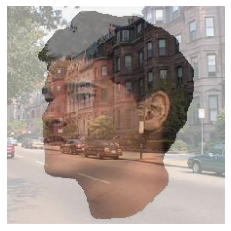

In [ ]:
# Merged images load
data_train = [[]  for i in range(12)]
data_train[0] = convertimgs('/content/merge/merge_train/Correct/Male',noise = False)  #75
data_train[1] = convertimgs('/content/merge/merge_train/Correct/Female/',noise = False) #75
data_train[2] = convertimgs('/content/merge/merge_train/Correct/Manmade/',noise = False) #75
data_train[3] = convertimgs('/content/merge/merge_train/Correct/Natural/',noise = False) #75
data_train[4] = convertimgs('/content/merge/merge_train/Correct/Powered',noise = False) #75
data_train[5] = convertimgs('/content/merge/merge_train/Correct/Nonpowered',noise = False) #75

data_train[6] = convertimgs('/content/merge/merge_train/Incorrect/Male',noise = False) #75
data_train[7] = convertimgs('/content/merge/merge_train/Incorrect/Female',noise = False) #75
data_train[8] = convertimgs('/content/merge/merge_train/Incorrect/Manmade',noise = False) #75
data_train[9] = convertimgs('/content/merge/merge_train/Incorrect/Natural',noise = False) #75
data_train[10] = convertimgs('/content/merge/merge_train/Incorrect/Powered',noise = False) #75
data_train[11] = convertimgs('/content/merge/merge_train/Incorrect/Nonpowered',noise = False) #75
data_train = np.array(data_train)
 
data_test = [[]  for i in range(12)]
data_test[0] = convertimgs('/content/merge/merge_test/Correct/Male',noise = False)  #75
data_test[1] = convertimgs('/content/merge/merge_test/Correct/Female/',noise = False) #75
data_test[2] = convertimgs('/content/merge/merge_test/Correct/Manmade/',noise = False) #75
data_test[3] = convertimgs('/content/merge/merge_test/Correct/Natural/',noise = False) #75
data_test[4] = convertimgs('/content/merge/merge_test/Correct/Powered',noise = False) #75
data_test[5] = convertimgs('/content/merge/merge_test/Correct/Nonpowered',noise = False) #75

data_test[6] = convertimgs('/content/merge/merge_test/Incorrect/Male',noise = False) #75
data_test[7] = convertimgs('/content/merge/merge_test/Incorrect/Female',noise = False) #75
data_test[8] = convertimgs('/content/merge/merge_test/Incorrect/Manmade',noise = False) #75
data_test[9] = convertimgs('/content/merge/merge_test/Incorrect/Natural',noise = False) #75
data_test[10] = convertimgs('/content/merge/merge_test/Incorrect/Powered',noise = False) #75
data_test[11] = convertimgs('/content/merge/merge_test/Incorrect/Nonpowered',noise = False) #75
data_test = np.array(data_test)


print(data_train.shape,data_test.shape)

plt.imshow(data_train[0,1])
plt.axis('off')

# Regular Images load

reg_train = [[]  for i in range(12)]
reg_train[0] = convertimgs('/content/merge/merge_reg_train/Correct/Male',noise = False)  # 75
reg_train[1] = convertimgs('/content/merge/merge_reg_train/Correct/Female',noise = False) # 75
reg_train[2] = convertimgs('/content/merge/merge_reg_train/Correct/Manmade',noise = False) # 75
reg_train[3] = convertimgs('/content/merge/merge_reg_train/Correct/Natural/',noise = False) # 75
reg_train[4] = convertimgs('/content/merge/merge_reg_train/Correct/Powered',noise = False) # 75
reg_train[5] = convertimgs('/content/merge/merge_reg_train/Correct/Nonpowered',noise = False) # 75

reg_train[6] = convertimgs('/content/merge/merge_reg_train/Incorrect/Male',noise = False)  # 75
reg_train[7] = convertimgs('/content/merge/merge_reg_train/Incorrect/Female',noise = False) # 75
reg_train[8] = convertimgs('/content/merge/merge_reg_train/Incorrect/Manmade',noise = False) # 75
reg_train[9] = convertimgs('/content/merge/merge_reg_train/Incorrect/Natural/',noise = False) # 75
reg_train[10] = convertimgs('/content/merge/merge_reg_train/Incorrect/Powered',noise = False) # 75
reg_train[11] = convertimgs('/content/merge/merge_reg_train/Incorrect/Nonpowered',noise = False) # 75
reg_train = np.array(reg_train)


reg_test = [[]  for i in range(12)]
reg_test[0] = convertimgs('/content/merge/merge_reg_test/Correct/Male',noise = False)  #75
reg_test[1] = convertimgs('/content/merge/merge_reg_test/Correct/Female/',noise = False) #75
reg_test[2] = convertimgs('/content/merge/merge_reg_test/Correct/Manmade/',noise = False) #75
reg_test[3] = convertimgs('/content/merge/merge_reg_test/Correct/Natural/',noise = False) #75
reg_test[4] = convertimgs('/content/merge/merge_reg_test/Correct/Powered',noise = False) #75
reg_test[5] = convertimgs('/content/merge/merge_reg_test/Correct/Nonpowered',noise = False) #75

reg_test[6] = convertimgs('/content/merge/merge_reg_test/Incorrect/Male',noise = False) #75
reg_test[7] = convertimgs('/content/merge/merge_reg_test/Incorrect/Female',noise = False) #75
reg_test[8] = convertimgs('/content/merge/merge_reg_test/Incorrect/Manmade',noise = False) #75
reg_test[9] = convertimgs('/content/merge/merge_reg_test/Incorrect/Natural',noise = False) #75
reg_test[10] = convertimgs('/content/merge/merge_reg_test/Incorrect/Powered',noise = False) #75
reg_test[11] = convertimgs('/content/merge/merge_reg_test/Incorrect/Nonpowered',noise = False) #75
reg_test = np.array(reg_test)

print(reg_train.shape,reg_test.shape)



# Tuning Value Calculation

In [ ]:
categories = ['Male','Female','Manmade','Natural','Powered','Nonpowered']
calc_tun_activ = 0

if calc_tun_activ:
  for cat in range(6): 

    print('Category of interest: ', categories[cat])
    train_it = reg_train[cat]

    layer_names = [layer.name for layer in model.layers if 'conv' in layer.name]
    layer_outputs = [layer.output for layer in model.layers if layer.name in layer_names]
    activation_model = Model(inputs=model.input, outputs=layer_outputs)


    start = time.time()
    tun_activ = tc.calc_tun(train_it,activation_model,layer_names)
    print(f'Elapsed: {time.time() - start}s')

    with open('tuning_values_' + str(cat), 'wb') as fp:
      pickle.dump(tun_activ, fp)



### Load tuning activities

In [ ]:
tun_activ = []
for interest in range(6): 
  with open ('/content/drive/My Drive/obj/tuning_values_' + str(interest), 'rb') as fp:
      tun_activ.extend(pickle.load(fp))
len(tun_activ)



240

### Calculation of tuning values for each map

In [ ]:
ncats = 6
# to fish out each category tun_activations
labels = np.array([0] * 40 + [1] * 40 + [2] * 40 + [3] * 40 + [4] * 40 + [5] * 40)
cat_tun = [[[] for j in range(len(tun_activ[0]))] for i in range(ncats)]

avg_tun_activ = tc.calc_avg(tun_activ) #average tuning activity for each map
std_tun_activ = tc.calc_std(tun_activ,avg_tun_activ) #std tuning activity for each map

for i in range(ncats):
  #Calculating average activity of each
  #feature map in response to images of respective category, 
  #with the mean activity under all image categories subtracted from it
  idx = list(np.where(labels == i))
  cat_tun[i] = tc.calc_avg([tun_activ[i] for i in idx[0]])

# Vector of tuning values for each obj cataegory
fc = [[[0 for item in subl] for subl in cat_tun[0]] for i in range(ncats)]
#fc has length of ncats x nlayers x no of maps in each layer
for cat in range(ncats):
  for layer in range(len(cat_tun[cat])):
    for map in range(len(cat_tun[cat][layer])):
      if std_tun_activ[layer][map] == 0:
        continue
      fc[cat][layer][map] = (cat_tun[cat][layer][map] - 
                                avg_tun_activ[layer][map])/std_tun_activ[layer][map]


### Tuning quality

(0.0, 50.0)

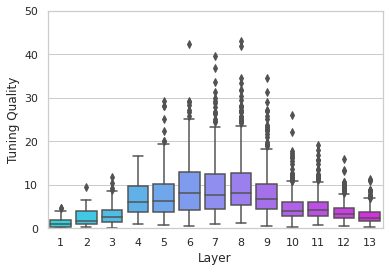

In [ ]:
tun_quality = tc.calc_tun_quality(fc)
sns.set(style="whitegrid")
ax = sns.boxplot(data = tun_quality,palette='cool')
ax.set_xlabel('Layer')
ax.set_xticklabels(np.arange(1,14))
ax.set_ylabel('Tuning Quality')
ax.set_ylim([0,50])

(0.0, 30.0)

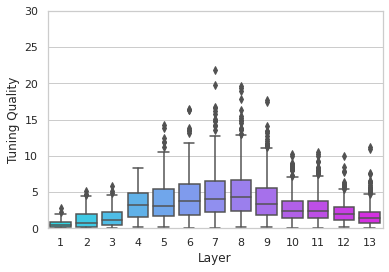

In [ ]:
tun_q_face = [[0 for item in subl] for subl in fc[0]]
for cat in range(2):
  for layer in range(len(fc[cat])):
    for map in range(len(fc[cat][layer])):
      if tun_q_face[layer][map] < abs(fc[cat][layer][map]):
        tun_q_face[layer][map] = abs(fc[cat][layer][map])

sns.set(style="whitegrid")
ax = sns.boxplot(data = tun_q_face,palette='cool')
ax.set_xlabel('Layer')
ax.set_xticklabels(np.arange(1,14))
ax.set_ylabel('Tuning Quality')
ax.set_ylim([0,30])

# Model Architecture

In [ ]:
# Calling VGG16 without the top FC layers with weights loaded from imagenet 
model = VGG16(weights='imagenet',
              include_top=False,input_shape = [224,224,3])
#plot_model(model,show_shapes=True,expand_nested=True)
#model.save_weights('vgg_w',save_format='h5')

categories = ['Male','Female','Manmade','Natural','Powered','Nonpowered']
interest = 0
print('Category of interest: ', categories[interest])
train_it = np.concatenate((reg_train[interest],reg_train[interest + 6]))
test_it = np.concatenate((reg_test[interest],reg_test[interest + 6]))
print(train_it.shape,test_it.shape)

start = time.time()
features_train = model.predict(train_it) 
print(f'Train Time: {time.time() - start}')

start = time.time()
features_test = model.predict(test_it) 
print(f'Test Time: {time.time() - start}')
epochs = 30

ntrain = 80
train_labels = to_categorical([0] * ntrain + [1]*ntrain)


ntest = 40
test_labels = to_categorical([0] * ntest + [1]*ntest) 

losses = 'binary_crossentropy'

# Initialize the top model with FC layers. These are the only ones to be trained
top_model = Sequential()
top_model.add(Flatten(input_shape=features_train.shape[1:])) 
top_model.add(Dense(4096, activation='relu',name = 'top_dense1')) 
top_model.add(Dense(2, activation='softmax',name = 'predictions'))

top_model.compile(optimizer= Adam(lr=1e-5),
              loss=losses,
              metrics=['accuracy'])
model.summary()

es = EarlyStopping(monitor='loss', mode='min', verbose=1)


Category of interest:  Male
(160, 224, 224, 3) (80, 224, 224, 3)
Train Time: 4.151860237121582
Test Time: 1.084580421447754
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___

# Attn

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Oct 10 02:39:43 2020

@author: soukhind
"""
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Activation
from tensorflow.keras.activations import relu
from keras.utils.generic_utils import get_custom_objects
from tensorflow.keras.callbacks import EarlyStopping
from vis.utils import utils
from tensorflow.python.ops import nn
from tensorflow import math
import time
from sklearn.metrics import roc_curve,accuracy_score,precision_recall_curve,f1_score
from sklearn.manifold import TSNE


def gen_attnmap(modifier,mask,category,bi,atype):
    """
    

    Parameters
    ----------
    modifier : list
        modifier to be used to implement attention.
    mask : ndarray
        binary vector to determine which layer to apply attention at. 
        include attention strength by multiplying to it
    category : ndarray
        cateogies .
    bi : boolean 
        bidirectionality
        True & False.
    atype: int
        1 = Multiplicative
        2 = Additive
    Returns
    -------
    tensor_attnmap : tensor
        attention map.

    """
    attnmap = []
    #beta = calc_beta(avg_tun_activ)/10
  
    #conv1_1 & conv1_2
    for layer in range(2):
        mapval = np.float32(modifier[category][layer])
        if bi == False:
            mapval[mapval < 0] = 0
        if atype == 1:
          amap = np.ones((224,224,64),dtype='float32') + np.tile(mapval,[224,224,1])* mask[layer]
        elif atype == 2:
          amap = np.tile(mapval,[224,224,1])* mask[layer]
        #amap[amap < 0] = 0
        attnmap.append(amap)
    
    #conv2_1 & conv2_2
    for layer in range(2,4):
        mapval = np.float32(modifier[category][layer])
        if bi == False:
            mapval[mapval < 0] = 0
        if atype == 1:
          amap = np.ones((112,112,128),dtype='float32') + np.tile(mapval,[112,112,1])* mask[layer]
        elif atype == 2:
          amap = np.tile(mapval,[112,112,1])* mask[layer]
        #amap[amap < 0] = 0
        attnmap.append(amap)
    
    #conv3_1 - conv3_3
    for layer in range(4,7):
        mapval = np.float32(modifier[category][layer])
        if bi == False:
            mapval[mapval < 0] = 0
        if atype == 1:
          amap = np.ones((56,56,256),dtype='float32') + np.tile(mapval,[56,56,1])* mask[layer]
        elif atype == 2:
          amap = np.tile(mapval,[56,56,1])* mask[layer]
        #amap[amap < 0] = 0
        attnmap.append(amap)
    
    #conv4_1 - conv4_3
    for layer in range(7,10):
        mapval = np.float32(modifier[category][layer])
        if bi == False:
            mapval[mapval < 0] = 0
        if atype == 1:
          amap = np.ones((28,28,512),dtype='float32') + np.tile(mapval,[28,28,1])* mask[layer]
        elif atype == 2:
          amap = np.tile(mapval,[28,28,1])* mask[layer]
        #amap[amap < 0] = 0
        attnmap.append(amap)
    
    #conv5_1 - conv5_3
    for layer in range(10,13):
        mapval = np.float32(modifier[category][layer])
        if bi == False:
            mapval[mapval < 0] = 0
        if atype ==1:
          amap = np.ones((14,14,512),dtype='float32') + np.tile(mapval,[14,14,1])* mask[layer]
        elif atype == 2:
          amap = np.tile(mapval,[14,14,1])* mask[layer]
        #amap[amap < 0] = 0
        attnmap.append(amap)
    
    tensor_attnmap = []
    for layer in range(len(attnmap)):
      tensor_attnmap.append(tf.convert_to_tensor(attnmap[layer])) 
    
    return tensor_attnmap

def calc_tsne_plots(model,data,layer1,model_type):
  """

    Parameters
    ----------
    model : Tensorflow Model
        The model that is of interest
        
    data : ndarray
        Testing data
    layer1 : layer name whose activations are to be extracted
        string
    model_type : int
        Type of model
        0 = Base Model
        1 = Top Model
    Returns
    -------
    fig
        Figure object

    """


  out = model.get_layer(layer1).output
  model_out = Model(model.input,out)
  tsne = TSNE()

  features = model_out.predict(data) 

  catunits = np.zeros((len(features),1000))
  
  if model_type == 0:
    for image in range(len(features)):
      x = np.ndarray.flatten(features[image])
      catunits[image,:] = np.random.choice(x,1000)
    reduced = tsne.fit_transform(catunits)
  
  else:
    reduced = tsne.fit_transform(features)

  reduced_transformed = reduced - np.min(reduced, axis=0)
  reduced_transformed /= np.max(reduced_transformed, axis=0)
  image_xindex_sorted = np.argsort(np.sum(reduced_transformed, axis=1))
  fig = plt.figure(figsize = (10,10))
  palette = sns.color_palette("bright", 2)
  ax = sns.scatterplot(x = reduced[:,0], y = reduced[:,1], 
                hue = [0] * ntest + [1]*ntest,
                style = [0] * ntest + [1]*ntest,
                markers = ['v','X'], s = 300,
                  legend='full', palette=palette)
  plt.axis( 'off')
  return fig

def avg_accuracy(data_train,train_labels,
                 data_test,test_labels,
                 modifier,
                 model,top_model,idxpath,
                 category,
                 atstrng,
                 bidir = True,
                 atype = 1):
    """
    

    Parameters
    ----------
    data_train : ndarray
        Training data.
    train_labels : categorical
        Training labels.
    data_test : ndarray
        Testing data.
    test_labels : categorical
        Testing labels.
    category : int
        Catrgory index
    modifier : list
        modifier to be used to implement attention.
    model : keras model
        base model.
    top_model : keras model
        top model.
    idxpath : string
        for internal use.
    atstrng : float32
        attention strength.
    bidir : bool, optional
        Bidirectionality. The default is True.
    atype: int
        1 = Multiplicative
        2 = Additive
    Returns
    -------
    t_acc
        Accuracy for each category at each layer.

    """
    categories = ['Male','Female','Manmade','Natural','Powered','Nonpowered']

    epochs = 30    
    n_layers = 13
    t_acc = np.zeros(n_layers)
    thr = np.zeros(n_layers)
    for li in range(n_layers):
        layermask = np.zeros(13)
        layermask[li] = 1
        tensor_attnmap = gen_attnmap(modifier,layermask*atstrng,category,bidir,atype)
        
        
        def attnrelu(x,map = tensor_attnmap,atype = atype):
            layeridx = np.load(idxpath)
            if layeridx == 13:
                layeridx = 0
            if atype == 1:
              x = nn.relu(x)
              activations = math.multiply(x,map[layeridx])
            if atype == 2:
              activations = math.add(x,map[layeridx])
              activations = nn.relu(activations)
            layeridx += 1
            np.save(idxpath,layeridx)
            return activations
    
        get_custom_objects().update({'attnrelu': Activation(attnrelu)})
    
        for layer in model.layers:
            if(hasattr(layer,'activation')):
                layer.activation = attnrelu
    
        utils.apply_modifications(model)
        model.compile()
        
        f_train = model.predict(data_train)     
    
        f_test = model.predict(data_test)

        fig = calc_tsne_plots(model,data_test,
                        layer1 = 'block5_conv3',
                        model_type = 0
                        )
        fig.suptitle('Category: ' + categories[category] +
                     ', layer ' + str(li + 1) +
                     ', atstg ' + str(atstrng) + ', base_model', fontsize = 12)
        fig.savefig('/content/tsne_iamgenet_plots/tsne_base_cat'+ str(category) +
                    '_lyr' + str(li + 1) + '_astg' +  str(atstrng))
        plt.close()
        es = EarlyStopping(monitor='loss', mode='min', verbose=1)
  
        history = top_model.fit(x = f_train,  y = train_labels,
                epochs=epochs,
                batch_size=64,
                verbose = 0, callbacks = [])
        
        fig = calc_tsne_plots(top_model,f_test,
                        layer1 = 'top_dense2',
                        model_type = 1
                        )
        fig.suptitle('Category: ' + categories[category] +
                     ', layer ' + str(li + 1) +
                     ', atstg ' + str(atstrng) + ', top_model', fontsize = 12)
        fig.savefig('/content/tsne_iamgenet_plots/tsne_top_cat'+ str(category) +
                    '_lyr' + str(li) + '_astg' +  str(atstrng))
        plt.close()

        out = top_model.evaluate(f_test, test_labels)
        t_acc[li] = out[1]

    return t_acc


def calc_beta(avg_act):
  beta = [0 for item in avg_act]
  for layer in range(len(avg_act)):
    for item in avg_act[layer]:
      beta[layer] += np.mean(item)
      beta = np.array(beta)
  return beta

In [ ]:
##@title Multiplicative and bidirectionality corrected
if os.path.isfile('tsne_iamgenet_plots/'):
  os.mkdir('tsne_iamgenet_plots/')
from vgg16obj.tools import model_calcs as mc
import gc
layeridx = 0
np.save('layeridx',layeridx)
#atstrng = 10.5 #0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10
for atstrng in np.arange(5,10,1): #Calling for different attn strengths
  grand_acc = [[] for i in range(6)] 
  for cat in range(6): # Iterating over 6 categories
    tf.keras.backend.clear_session()
    print('Category of interest: ', categories[cat])
    train_it = np.concatenate((reg_train[cat],reg_train[cat + 6])) # Training on regular data
    test_it = np.concatenate((data_test[cat],data_test[cat + 6])) # Testing on merged data
    print(train_it.shape,test_it.shape)
    model = VGG16(weights= None,
                        include_top=False,input_shape = [224,224,3])
    
    top_model = Sequential()
    top_model.add(Flatten(input_shape=features_train.shape[1:])) 
    top_model.add(Dense(4096, activation='relu',name = 'top_dense1')) 
    top_model.add(Dense(4096, activation='relu',name = 'top_dense2')) 
    top_model.add(Dense(2, activation='sigmoid',name = 'predictions'))
    top_model.compile(optimizer= Adam(lr=1e-5),
                loss='binary_crossentropy',
                metrics=['accuracy'])
    
    # Read avg_accuracy's definition to learn about the parameters
    grand_acc[cat] = avg_accuracy(train_it,
                              train_labels,
                              test_it,
                              test_labels,
                              fc,
                              model,
                              top_model,
                              '/content/layeridx.npy',
                              cat,
                              atstrng,
                              bidir = True,
                              atype = 1 )
  grand_acc = np.array(grand_acc)
  grand_acc.reshape([1,6,13])
  # Use tun_accuracy_multi for multiplicative mode (atype = 1) and
  # use tun_accuracy_bias for bias mode (atype = 2)
  np.save('tun_accuracy_multi' + str(atstrng),grand_acc)



### Regular Accuracy
Calculate the regular accuracy so that they can be contrasted against when attention is applied.

In [ ]:
# Reinitialising the models for calculating regular accuracy
model = VGG16(weights='imagenet',
                        include_top=False,input_shape = [224,224,3])
          
top_model = Sequential()
top_model.add(Flatten(input_shape=features_train.shape[1:])) 
top_model.add(Dense(4096, activation='relu',name = 'top_dense1')) 
top_model.add(Dense(2, activation='sigmoid',name = 'predictions'))
top_model.compile(optimizer= Adam(lr=1e-5),
            loss='categorical_crossentropy',
            metrics=['accuracy'])
    
categories = ['Male','Female','Manmade','Natural','Powered','Nonpowered']
acc = [0]*6
for cat in range(6):
  tf.keras.backend.clear_session()

  print('Category of interest: ', categories[cat])
  train_it = np.concatenate((reg_train[cat],reg_train[cat + 6]))
  test_it = np.concatenate((data_test[cat],data_test[cat + 6]))
  print(train_it.shape,test_it.shape)


  #plot_model(model,show_shapes=True,expand_nested=True)
  #model.save_weights('vgg_w',save_format='h5')

  features_train = model.predict(train_it) 

  features_test = model.predict(test_it) 


  epochs = 30
  #train_data = np.load('features_train.npy')
  ntrain = 80
  train_data = features_train
  train_labels = to_categorical([0] * ntrain + [1]*ntrain)


  #test_data = np.load('features_test.npy')
  ntest = 40
  test_data = features_test
  test_labels = to_categorical([0] * ntest + [1]*ntest)



  es = EarlyStopping(monitor='loss', mode='min', verbose=1)

  history = top_model.fit(x = train_data,  y = train_labels,
            epochs=epochs,
            batch_size=64,
            verbose = 0, callbacks = [es])

  out = top_model.evaluate(test_data, test_labels)
  print(out)
  acc[cat] = out[1]
  #print('rounded test labels',pred)
np.mean(acc)

Category of interest:  Male
(160, 224, 224, 3) (80, 224, 224, 3)
3/3 [==============================] - 0s 5ms/step - loss: 0.6972 - accuracy: 0.7000
[0.6971968412399292, 0.699999988079071]
Category of interest:  Female
(160, 224, 224, 3) (80, 224, 224, 3)
3/3 [==============================] - 0s 5ms/step - loss: 0.8193 - accuracy: 0.7125
[0.8192527890205383, 0.7124999761581421]
Category of interest:  Manmade
(160, 224, 224, 3) (80, 224, 224, 3)
Epoch 00005: early stopping
3/3 [==============================] - 0s 6ms/step - loss: 1.1501 - accuracy: 0.6375
[1.1501230001449585, 0.637499988079071]
Category of interest:  Natural
(160, 224, 224, 3) (80, 224, 224, 3)
Epoch 00003: early stopping
3/3 [==============================] - 0s 5ms/step - loss: 2.0884 - accuracy: 0.5875
[2.088399887084961, 0.5874999761581421]
Category of interest:  Powered
(160, 224, 224, 3) (80, 224, 224, 3)
3/3 [==============================] - 0s 6ms/step - loss: 0.7062 - accuracy: 0.6625
[0.7062070965766907, 0

0.6583333214124044

Text(0, 0.5, 'Performance Increase (%)')

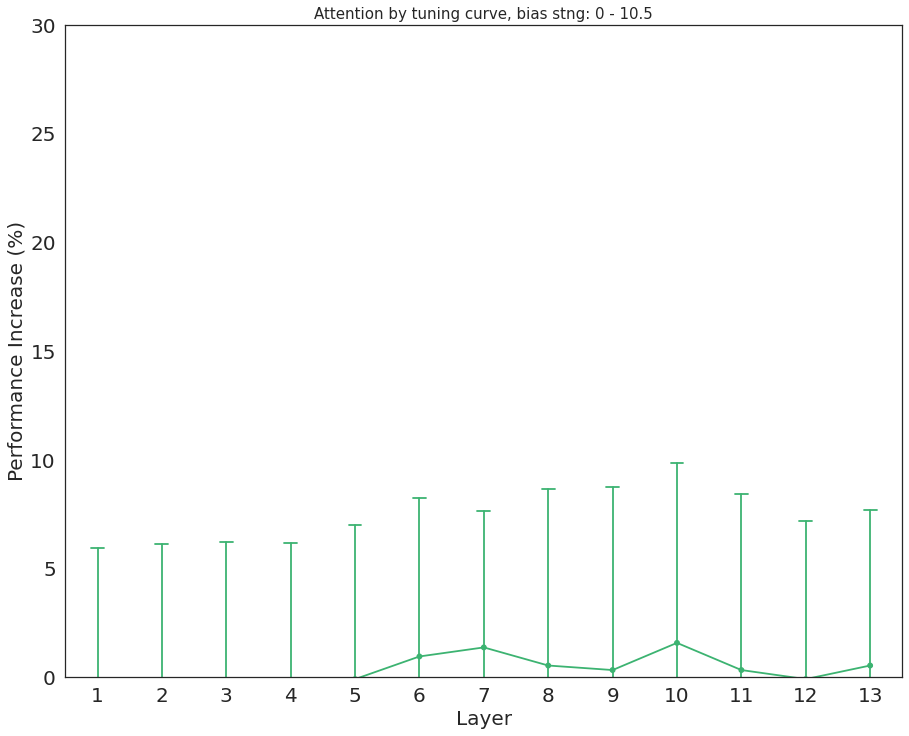

In [ ]:
acc = [0.69,0.72,0.85,0.58,0.66,0.63]


x = np.load('tun_accuracy_multi0.npy')
x = np.expand_dims(x,0)

for i in np.arange(1,10,1):
  temp = np.load('tun_accuracy_multi' + str(i) + '.npy')
  temp = np.expand_dims(temp,0)
  x = np.vstack((x,temp))



x = np.amax(x,0)

plt_data = np.zeros((6,13))
for i in range(6):
  for j in range(13):
    plt_data[i,j] = x[i,j] - acc[i]


import seaborn as sns
sns.set(style="white",rc={"lines.linewidth": 1})
plt.figure(figsize = (15,12))
ax = sns.pointplot(data = plt_data*100, color = 'mediumseagreen',
                   errorwidth = 0.1 , capsize = 0.2)
                   
ax.set_xlabel('Layer',size = 20)
ax.set_xticklabels(np.arange(1,14),size = 20)
plt.yticks(fontsize = 20)
plt.ylim(0,30)
plt.title('Attention by tuning curve, bias stng: 0 - 10.5',size = 15)
ax.set_ylabel('Performance Increase (%)',size = 20)

In [ ]:
x = np.load('tun_accuracy_multi0.npy')
x = np.expand_dims(x,0)

for i in np.arange(1,10,1):
  temp = np.load('tun_accuracy_multi' + str(i) + '.npy')
  temp = np.expand_dims(temp,0)
  x = np.vstack((x,temp))

x_0 = x[:,0,:]
x_1 = x[:,1,:]
x_2 = x[:,2,:]
x_3 = x[:,3,:]
x_4 = x[:,4,:]
x_5 = x[:,5,:]

print(np.unravel_index(x_0.argmax(),x_0.shape))
print(np.unravel_index(x_1.argmax(),x_1.shape))
print(np.unravel_index(x_2.argmax(),x_2.shape))
print(np.unravel_index(x_3.argmax(),x_3.shape))
print(np.unravel_index(x_4.argmax(),x_4.shape))
print(np.unravel_index(x_5.argmax(),x_5.shape))
x[1,0,0]

(1, 0)
(2, 4)
(7, 6)
(0, 9)
(0, 5)
(0, 6)


0.8374999761581421